# **Chapter 01-2 금융 데이터와 전처리**

## **6 자산 수익의 정형화된 사실의 조사**
**정형화된 사실(Styled fact)** 에서는 **경험적 자산 수익률** 에서 나타나는 **통계적 분석 속성** 을 분석 합니다
- ! pip install statsmodels

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Visualization Setting
import warnings
import matplotlib.pyplot as plt
# plt.rc('font', family='NanumGothic')
plt.rcParams["font.family"] = 'NanumGothicCoding'
plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 300
plt.rc('axes', unicode_minus=False)
warnings.simplefilter(action='ignore', category=FutureWarning)

## **6-1 Reading the Stock DataSet**

In [2]:
import numpy as np
import pandas as pd

# read Stock CSV dataset
data_stock = pd.read_csv('./data/stock.csv')
data_stock['Date'] = pd.to_datetime(data_stock['Date'])
data_stock = data_stock.set_index('Date')

df = data_stock.loc[:, ['Close']]  # DataFrame 으로 데이터 추출
df.rename(columns={'Close':'adj_close'}, inplace=True)

# 추가 수익률 계산내용의 추가
df['simple_rtn'] = df.adj_close.pct_change()                  # 단순 수익률 계산 (자산기준 수익률 가중화 합산)
df['log_rtn'] = np.log(df.adj_close / df.adj_close.shift(1))  # Log 수익률 계산 (시간에 따른 수익률 log 합산)
df = df.dropna()
df.head(3)

,adj_close,simple_rtn,log_rtn
Date,,,
1999-01-05,1673,-0.011813,-0.011884
1999-01-06,1718,0.026898,0.026542
1999-01-07,1841,0.071595,0.069148


In [3]:
import scipy.stats as scs

# 관측한 수익률의 평균과 표준편차를 계산하여, 
# 정규분포 확률 밀도함수 (Probability Density Function) 을 계산한다
r_range = np.linspace(min(df.log_rtn), max(df.log_rtn), num=1000)
mu = df.log_rtn.mean()
sigma = df.log_rtn.std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)

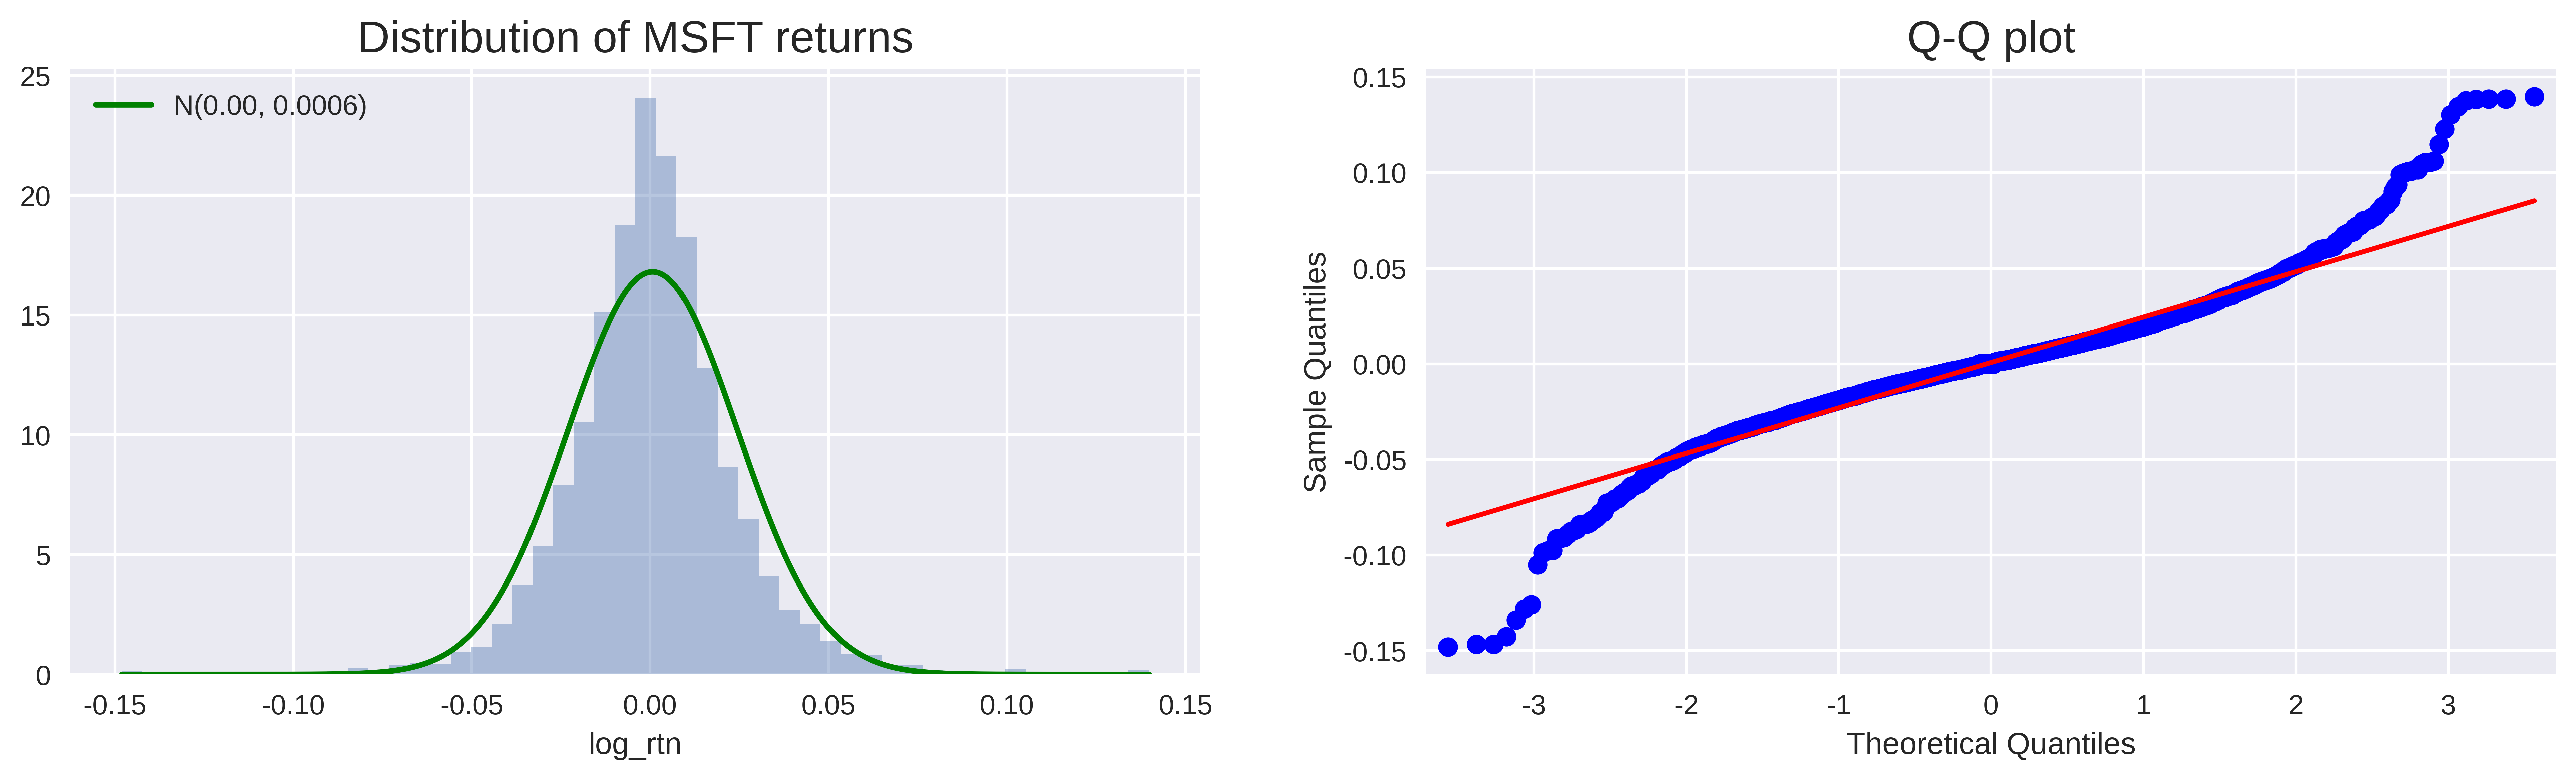

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

# Histogram 그리기
import seaborn as sns
sns.distplot(df.log_rtn, kde=False, norm_hist=True, ax=ax[0])                                    
ax[0].set_title('Distribution of MSFT returns', fontsize=16)                                                    
ax[0].plot(r_range, norm_pdf, 'g', lw=2, 
           label=f'N({mu:.2f}, {sigma**2:.4f})')
ax[0].legend(loc='upper left');

# Q-Q plot 그리기
import statsmodels.api as sm
qq = sm.qqplot(df.log_rtn.values, line='s', ax=ax[1])
ax[1].set_title('Q-Q plot', fontsize = 16)
# plt.tight_layout()
# plt.savefig('images/ch1_im10.png')
plt.show()

In [5]:
# 통계적인 방법을 활용하여 정규성 검정을 실시한다
jb_test = scs.jarque_bera(df.log_rtn.values)
print('---------- Descriptive Statistics ----------')
print('Range of dates:', min(df.index.date), '-', max(df.index.date))
print('Number of observations:', df.shape[0])
print(f'Mean: {df.log_rtn.mean():.4f}')
print(f'Median: {df.log_rtn.median():.4f}')
print(f'Min: {df.log_rtn.min():.4f}')
print(f'Max: {df.log_rtn.max():.4f}')
print(f'Standard Deviation: {df.log_rtn.std():.4f}')
print(f'Skewness(왜도): {df.log_rtn.skew():.4f}')
print(f'Kurtosis(첨도): {df.log_rtn.kurtosis():.4f}') 
print(f'Jarque-Bera (자르케-베라) statistic (정규성 검정): {jb_test[0]:.2f} with p-value: {jb_test[1]:.2f}')

---------- Descriptive Statistics ----------
Range of dates: 1999-01-05 - 2021-03-12
Number of observations: 5479
Mean: 0.0007
Median: 0.0000
Min: -0.1480
Max: 0.1398
Standard Deviation: 0.0237
Skewness(왜도): 0.1364
Kurtosis(첨도): 4.4594
Jarque-Bera (자르케-베라) statistic (정규성 검정): 4546.34 with p-value: 0.00


## **6-2 변동성 클러스터링**

<AxesSubplot:title={'center':'Daily S&500 returns'}, xlabel='Date'>

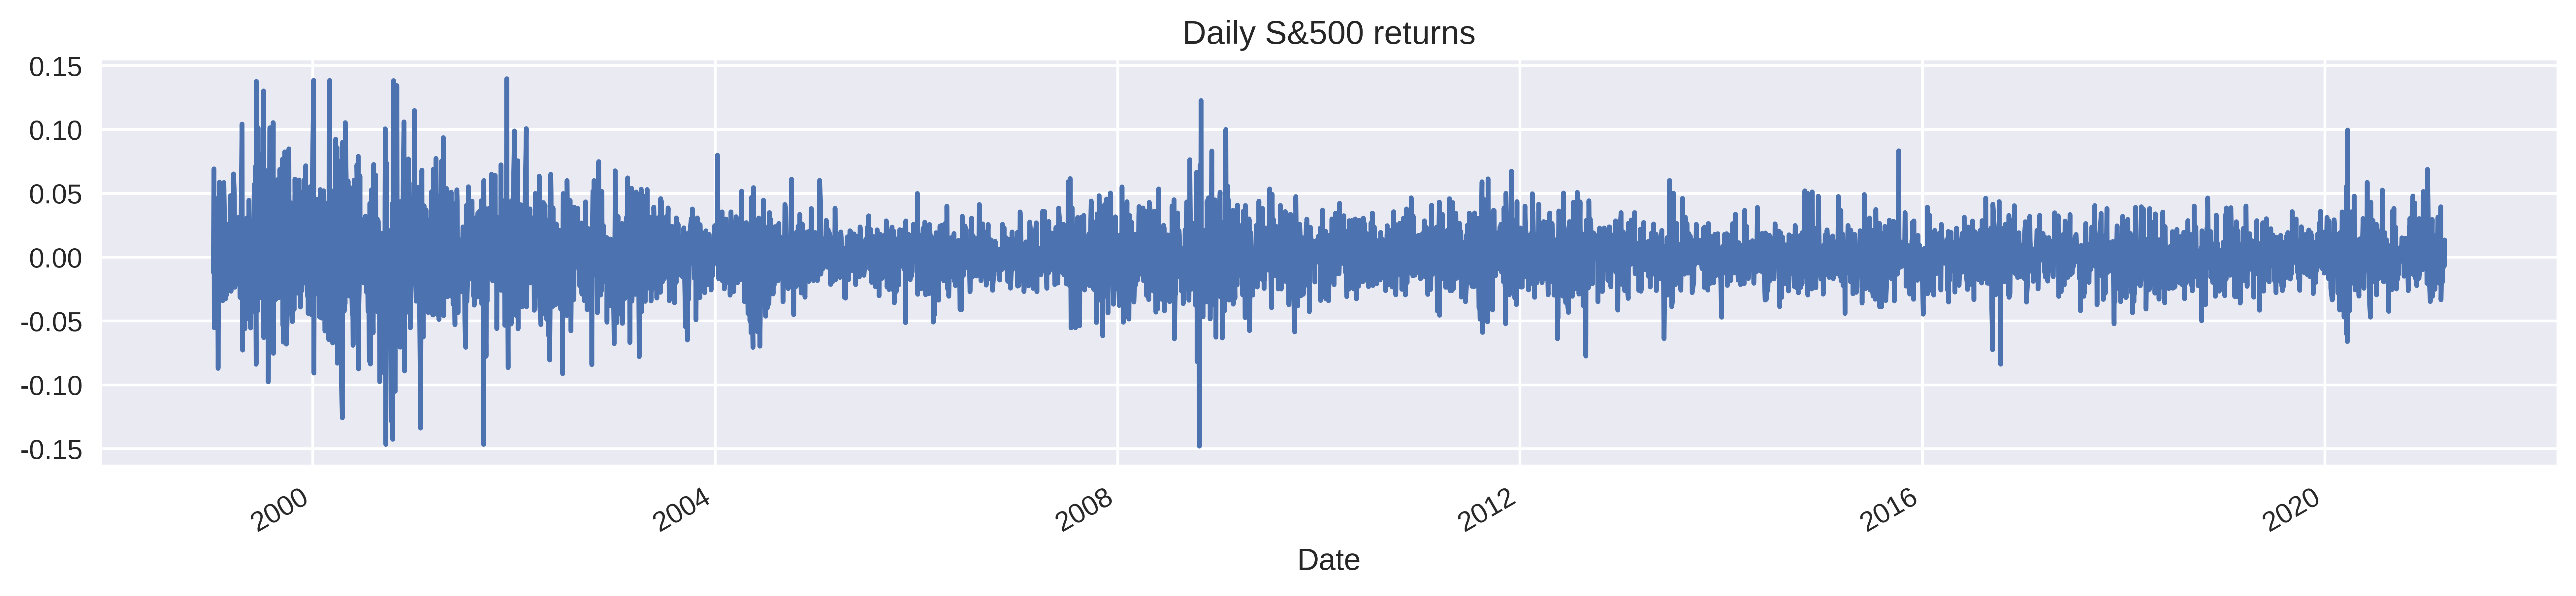

In [6]:
df.log_rtn.plot(figsize=(16, 3), title='Daily S&500 returns')

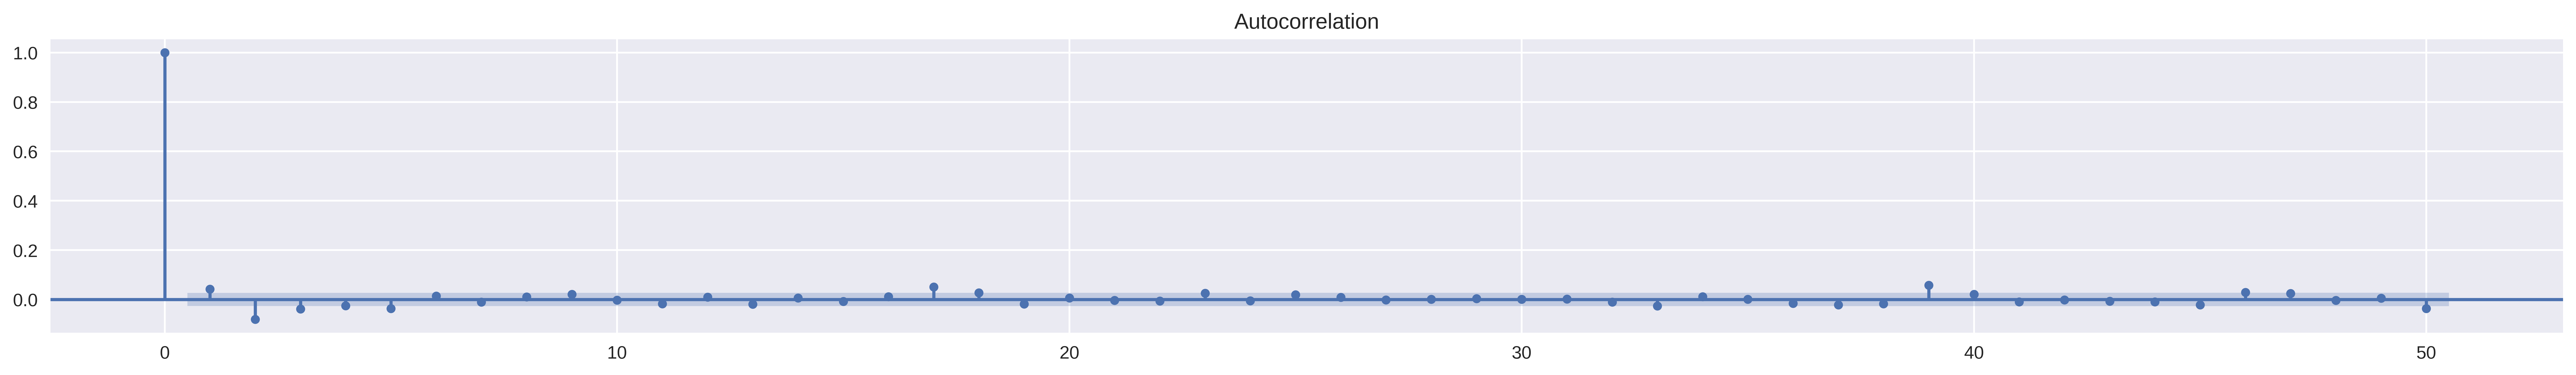

In [7]:
import statsmodels.tsa.api as smt

# 수익률과 자기 상관의 부재
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05

# 상관관계 함수를 활용하여 그림을 그린다
plt.rcParams['figure.figsize'] = (20.0, 3.0)
acf = smt.graphics.plot_acf(df.log_rtn, lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL)
plt.tight_layout()
plt.show()

## **6-3 제곱/ 절대 수익률에서 작게 감소하는 자기상관**